In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('datasets/Train.csv')

# ignore columns call_type	call_status	start_time	duration	end_time	display_location

df = df.drop(columns=['call_type', 'call_status', 'start_time', 'duration', 'end_time', 'display_location'])
df['conversions_calls'] = df['conversions_calls'].interpolate().fillna(df['conversions_calls'].interpolate().mean())


# Step 1: Identify numeric columns
numeric_columns = df.select_dtypes(include=['float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
df = df.dropna()


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289526 entries, 0 to 289525
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   impressions         289526 non-null  float64
 1   clicks              289526 non-null  float64
 2   cost                289526 non-null  float64
 3   conversions         289526 non-null  float64
 4   ad_type             289526 non-null  object 
 5   ID                  289526 non-null  object 
 6   date                289526 non-null  object 
 7   impression_share    289526 non-null  float64
 8   conversions_calls   289526 non-null  float64
 9   headline1_len       289526 non-null  float64
 10  headline2_len       289526 non-null  float64
 11  ad_description_len  289526 non-null  float64
dtypes: float64(9), object(3)
memory usage: 28.7+ MB


In [6]:
df['currency'].unique(), df['currency'].nunique()

(array(['ZAR', 'USD'], dtype=object), 2)

In [7]:
# Example exchange rates for ZAR and USD
exchange_rates = {'USD': 1.0, 'ZAR': 0.071}  # 1 USD = 0.071 ZAR

# Function to convert cost to USD
def convert_to_usd(currency, cost):
    exchange_rate = exchange_rates.get(currency, 1.0)  # Default to 1.0 if currency not found
    return cost * exchange_rate

# Update 'cost' column with cost in USD
df['cost'] = df.apply(lambda row: convert_to_usd(row['currency'], row['cost']), axis=1)

# Drop 'currency' column
df.drop(columns=['currency'], inplace=True)


In [11]:
# normalize the data using MinMaxScaler
# scale impressions, cost, impression_share, ad_description_len

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['impressions', 'cost', 'impression_share', 'ad_description_len']] = scaler.fit_transform(df[['impressions', 'cost', 'impression_share', 'ad_description_len']])


In [12]:
# display rows with ID ID_5e43c29e6279884e2827d894

df.loc[df['ID'] == 'ID_5e43c29e6279884e2827d894']['ad_type'].unique()

array(['EXPANDED_TEXT_AD', 'EXPANDED_DYNAMIC_SEARCH_AD'], dtype=object)

In [14]:
y = df['clicks']
X = df.drop(columns=['ID', 'clicks'])

X['ad_type'] = X['ad_type'].astype(str)



X['date'] = pd.to_datetime(X['date'])
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X = X.drop(['date'], axis=1)

In [16]:
# encode currency, ad_type
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X['ad_type'] = le.fit_transform(X['ad_type'])

df.head()

,impressions,clicks,cost,conversions,ad_type,ID,date,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,0.020782,15.0,0.004713,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,0.118733,0.0,2.0,5.0,0.55
1,0.013025,8.0,0.002524,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,0.118733,0.0,2.0,2.0,0.65
2,0.008635,8.0,0.002421,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,0.118733,0.0,2.0,2.0,0.50
3,0.011415,4.0,0.001274,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,0.118733,0.0,2.0,3.0,0.65
4,0.002927,1.0,0.000301,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,0.118733,0.0,2.0,2.0,0.65


In [17]:
_prepd_df = pd.concat([X, y], axis=1)

<Axes: >

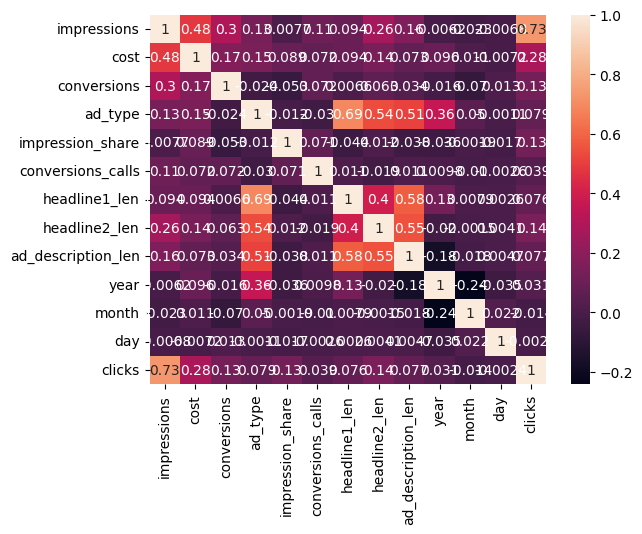

In [18]:
# plot correlation matrix
import seaborn as sns

corr = _prepd_df.corr()

sns.heatmap(corr, annot=True)

In [19]:
# from corr matrix, show features correlation with clicks

corr['clicks'].sort_values(ascending=False)


clicks                1.000000
impressions           0.734686
cost                  0.278523
headline2_len         0.144910
conversions           0.128776
impression_share      0.126332
ad_type               0.079040
ad_description_len    0.077180
headline1_len         0.075684
conversions_calls     0.038814
year                  0.030796
day                  -0.002419
month                -0.014417
Name: clicks, dtype: float64

In [20]:
# using the features with correlation > 0.1 from corr['clicks']

corr_features = corr['clicks'][corr['clicks'] > 0].index.drop('clicks')

In [21]:
%%capture
x = X[corr_features]
y = df['clicks']

# add date features for time series
x['year'] = X['year']
x['month'] = X['month']
x['day'] = X['day']

In [22]:
x.head()

,impressions,cost,conversions,ad_type,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,year,month,day
0,0.020782,0.004713,0.0,1,0.118733,0.0,2.0,5.0,0.55,2020,1,1
1,0.013025,0.002524,0.0,1,0.118733,0.0,2.0,2.0,0.65,2020,1,1
2,0.008635,0.002421,0.0,1,0.118733,0.0,2.0,2.0,0.50,2020,1,1
3,0.011415,0.001274,0.0,1,0.118733,0.0,2.0,3.0,0.65,2020,1,1
4,0.002927,0.000301,0.0,1,0.118733,0.0,2.0,2.0,0.65,2020,1,1


In [23]:
# length check
len(x) == len(y)

True

In [24]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# models

In [25]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
# from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Initialize and train models
models = {
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=3),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LinearRegression": LinearRegression(),
    # "SVR": SVR(),
    "ElasticNet": ElasticNet(),
    "BayesianRidge": BayesianRidge(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    # "GaussianProcessRegressor": GaussianProcessRegressor(),
    "MLPRegressor": MLPRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print("Trainig ", name)
    try:
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        mse = mean_squared_error(y_test, predictions)
        results[name] = mse
    except Exception as e:
        print(f"Error occurred while training {name}: {e}")
        results[name] = None  # Set MSE to None if an error occurs



# Print results
for name, mse in results.items():
    if mse is not None:
        rmse = sqrt(mse)
        print(f"{name} |--| Mean Squared Error: {mse}, |--| Root Mean Squared Error: {rmse}")
    else:
        print(f"{name} failed to train.")



Trainig  XGBoost
Trainig  RandomForest


In [ ]:
model_choice = "DecisionTreeRegressor"
model = models[model_choice]

# Submision file Generation / inference


In [ ]:
# model evaluation
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, model.predict(x_test))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')

XGB:
RMSE: 7.566170321350423
MSE: 57.24693333168397

RANDOM FOREST REGRESSOR:
RMSE: 4.72865723929903
MSE: 22.36019928677512

In [ ]:
def extract_id_and_date(string):
    parts = string.split('_')
    id_str = parts[1]
    date_str = '_'.join(parts[2:])
    return "ID_" + id_str, pd.to_datetime(date_str, format='%Y_%m_%d')


In [ ]:
# submission file
test_df = pd.read_csv('datasets/SampleSubmission.csv')

In [ ]:
test_df['id'], test_df['date'] = zip(*test_df['ID'].map(extract_id_and_date))
test_df['end_date'] = test_df['date'] + pd.Timedelta(days=6)

In [ ]:
test_df.head()

In [ ]:
test_row = test_df.iloc[0]
test_row['id']

In [ ]:

XX = X.copy()

In [ ]:
XX['date'] = pd.to_datetime(df['date'])

In [ ]:
XX['ID'] = df['ID']

In [ ]:
XX.head(3)


In [ ]:
def filter_df_by_id_or_date_range(df, id, start_date, end_date):
    """
    Filter DataFrame by ID or date range.

    Args:
    df (DataFrame): Input DataFrame to filter.
    id (str): ID to filter.
    start_date (str or Timestamp): Start date of the range.
    end_date (str or Timestamp): End date of the range.

    Returns:
    DataFrame: Filtered DataFrame containing rows within the specified ID or date range.
    """
    filtered = df[((df['ID'] == id) & (df['date'] >= start_date)) | ((df['ID'] == id) & (df['date'] <= end_date))]
    return filtered[x.columns]


# Iterate over each row in test_df
for index, test_row in test_df.iterrows():
    # Filter rows in XX based on the ID or date range from the current row
    filtered_df = filter_df_by_id_or_date_range(XX, test_row['id'], test_row['date'], test_row['end_date'])

    # Predict clicks for the filtered data
    clicks_predict = model.predict(filtered_df)

    # Calculate sum of clicks and update the 'clicks' column in test_df
    test_df.at[index, 'clicks'] = int(np.mean(clicks_predict))

print(test_df)


In [ ]:
# count clicks with 0s
test_df[test_df['clicks'] == 0].shape[0]

In [ ]:
test_df.head()

In [ ]:
test_df.to_csv("decision_regressive_attempt_attempt.csv", index=False)